# Modeling with Scikit-Learn Regressor

## 1. Preprocessing
- Lable-Encoding
- Log nomalization
- Standard scaling

# 2. Regressors : Scikit-Learn
- DecisionTree Regressor
- RandomForest Regressor
- Support Vector Regressor
- XGB Regressor
- Cross-validation 

# 3. Score by Model

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec
import utils.helpermodeling as hm
from scipy import stats

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import KFold, ParameterGrid, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

# model import
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cv = KFold(n_splits=10, shuffle=True, random_state=1)

In [2]:
def show_results(y_test, pred, measured, preds):
    print('\n')
    print("Train Test Split")
    print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))

    print('\n')
    print("Cross Validation")
    print('RMSE:', np.sqrt(mean_squared_error(measured, preds)))

    fig  = plt.figure(figsize=(8, 4), dpi=100)
    axes1 = fig.add_subplot(121)
    axes1.scatter(y_test, pred, c='red', s=5)
    axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes1.set_title("Train Test Split")
    axes1.set_xlabel('Measured')
    axes1.set_ylabel('Predicted')
    axes2 = fig.add_subplot(122)
    axes2.scatter(measured, preds, c='red', s=5)
    axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes2.set_title("Cross Validation")
    axes2.set_xlabel('Measured')
    axes2.set_ylabel('Predicted')
    fig.tight_layout()
    
    fig  = plt.figure(figsize=(8, 4), dpi=100);
    axes1 = fig.add_subplot(121); 
    axes1.scatter(y_test, y_test-pred, c='red', s=2)
    axes1.set_title("Train Test Split")
    axes1.set_xlabel('Measured')
    axes1.set_ylabel('Residual')
    axes2 = fig.add_subplot(122); 
    axes2.scatter(measured, measured-preds, c='red', s=2)
    axes2.set_title("Cross Validation")
    axes2.set_xlabel('Measured')
    axes2.set_ylabel('Residual')
    fig.tight_layout();
    
    fig  = plt.figure(figsize=(8, 4), dpi=100)
    axes1 = fig.add_subplot(121)
    axes2 = fig.add_subplot(122)
    sns.distplot((y_test-pred), bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "red"})
    sns.distplot((measured-preds), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "red"})
    axes1.set_title("Train Test Split")
    axes2.set_title("Cross Validation")
    axes1.set_xlim(-3, 3)
    axes2.set_xlim(-3, 3)
    

In [3]:
df_train = pd.read_csv('../input/train_macro_without_outliers.csv', index_col=0, parse_dates=['timestamp'])
df_train_augmented = pd.read_csv('../input/train_macro_with_outliers.csv', index_col=0, parse_dates=['timestamp'])
df_test = pd.read_csv('../input/test_macro.csv', index_col=0, parse_dates=['timestamp'])

## 1. Preprocessing

In [34]:
print(df_train.shape, df_train_augmented.shape, df_test.shape)

(24976, 243) (30404, 243) (32638, 242)


In [5]:
cate_features = [
 'detention_facility_raion',
 'culture_objects_top_25',
 'railroad_1line',
 'big_market_raion',
 'incineration_raion',
 'big_road1_1line',
 'radiation_raion',
 'railroad_terminal_raion',
 'ecology',
 'thermal_power_plant_raion',
 'oil_chemistry_raion',
 'nuclear_reactor_raion',
 'product_type',
 'water_1line'
]

numeric_features = list(df_train.columns.drop(cate_features + ['price_doc'] + ['timestamp']).values)

### Lable-Encoding

In [6]:
for f in cate_features:
    df_train[f].fillna(df_train[f].value_counts().index[0], inplace=True)
    df_test[f].fillna(df_test[f].value_counts().index[0], inplace=True)
    df_train_augmented[f].fillna(df_train_augmented[f].value_counts().index[0], inplace=True)
    
    lbl = LabelEncoder()
    lbl.fit(df_train[f].values)
    df_train[f] = lbl.transform(df_train[f].values)
    df_test[f] = lbl.transform(df_test[f].values)
    df_train_augmented[f] = LabelEncoder().fit_transform(df_train_augmented[f].values)

### Log nomalizaion

In [7]:
# Log Normalization of Numeric Features
for column in numeric_features + ['price_doc']:
    if stats.skew(df_train[column].values) > 1:
        df_train[column] = np.log(df_train[column] + 1)  
        df_train_augmented[column] = np.log(df_train_augmented[column] + 1)
        if column in df_test.columns.values:
            df_test[column]  = np.log(df_test[column] + 1)

### Standard scaling

In [8]:
# 평균 0 표준편차 1이 되도록 스케일링
train_scaler = StandardScaler()
train_scaler.fit(df_train[numeric_features])

scaled_numeric_train_X = train_scaler.transform(df_train[numeric_features])
df_scaled_numeric_train_X = pd.DataFrame(scaled_numeric_train_X, index=df_train.index, columns=numeric_features)
df_train = pd.concat([df_scaled_numeric_train_X, df_train[cate_features], df_train['price_doc']], axis=1)

scaled_numeric_test_X = train_scaler.transform(df_test[numeric_features])
df_scaled_numeric_test_X = pd.DataFrame(scaled_numeric_test_X, index=df_test.index, columns=numeric_features)
df_test = pd.concat([df_scaled_numeric_test_X, df_train[cate_features]], axis=1)

scaled_numeric_train_X = train_scaler.transform(df_train_augmented[numeric_features])
df_scaled_numeric_train_X = pd.DataFrame(scaled_numeric_train_X, index=df_train_augmented.index, columns=numeric_features)
df_train_augmented = pd.concat([df_scaled_numeric_train_X, df_train_augmented[cate_features], df_train_augmented['price_doc']],axis=1)

# 2. Regressors : Scikit-Learn
- Decision Tree Regressor
- RandomForest Regressor
- Support Vector Regressor
- XGB(Extreme Gradient Boosting) Regressor
- Cross-validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_train[numeric_features+cate_features], df_train['price_doc'], test_size=0.2, random_state=1)

### Decision Tree Regressor

In [10]:
dtr = DecisionTreeRegressor()
y_train_dtr, y_test_dtr = hm.regression(dtr, X_train, X_test, y_train)
hm.scores('Decision Tree Regressor', y_train, y_test, y_train_dtr, y_test_dtr)

______________________________________________
Decision Tree Regressor
______________________________________________
R2 score. Train:  0.9999983775091627
R2 score. Test:  0.8904869546933241
______________________________________________
MSE score. Train:  2.571249335533897e-07
MSE score. Test:  0.01831843398703886
______________________________________________
RMSE score. Train:  0.0005070748796315882
RMSE score. Test:  0.0005070748796315882
______________________________________________
MAE score. Train:  1.2031462530497244e-05
MAE score. Test:  0.09416988102997606


## RandomForest Regressor

In [11]:
rfr = RandomForestRegressor()
y_train_rfr, y_test_rfr = hm.regression(rfr, X_train, X_test, y_train)
hm.scores('RandomForest Regressor', y_train, y_test, y_train_rfr, y_test_rfr)

______________________________________________
RandomForest Regressor
______________________________________________
R2 score. Train:  0.9889840785381349
R2 score. Test:  0.9417057505697886
______________________________________________
MSE score. Train:  0.0017457528934233509
MSE score. Test:  0.009750978589088778
______________________________________________
RMSE score. Train:  0.04178220785721299
RMSE score. Test:  0.04178220785721299
______________________________________________
MAE score. Train:  0.027956660269124283
MAE score. Test:  0.0702270327181524


## Support Vector Regressor

In [12]:
svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
y_train_rfr, y_test_rfr = hm.regression(svr, X_train, X_test, y_train)
hm.scores('Support Vector Regressor', y_train, y_test, y_train_rfr, y_test_rfr)

______________________________________________
Support Vector Regressor
______________________________________________
R2 score. Train:  0.9357326739411266
R2 score. Test:  0.9314934784178499
______________________________________________
MSE score. Train:  0.010184792149095805
MSE score. Test:  0.011459202780545517
______________________________________________
RMSE score. Train:  0.100919731217913
RMSE score. Test:  0.100919731217913
______________________________________________
MAE score. Train:  0.08159051016507356
MAE score. Test:  0.084696464226569


## XGB Regressor

In [13]:
param_grid = [{
    'max_depth': [10],
    'learning_rate' : [0.1],
    'n_estimators' : [200], 
    'colsample_bytree': [0.5]
}]

xgr = xgb.XGBRegressor()
grid_xgr = GridSearchCV(xgr, param_grid, cv=cv, n_jobs=4, scoring='neg_mean_squared_log_error')
grid_xgr.fit(X_train, y_train)
print(grid_xgr.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [14]:
xgr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
y_train_xgr, y_test_xgr = hm.regression(xgr, X_train, X_test, y_train)
hm.scores('XGB Regressor', y_train, y_test, y_train_xgr, y_test_xgr)

______________________________________________
XGB Regressor
______________________________________________
R2 score. Train:  0.9947698927852873
R2 score. Test:  0.9576152979198477
______________________________________________
MSE score. Train:  0.0008288434911783736
MSE score. Test:  0.007089761452083816
______________________________________________
RMSE score. Train:  0.028789642081456547
RMSE score. Test:  0.028789642081456547
______________________________________________
MAE score. Train:  0.021077327875507146
MAE score. Test:  0.061100109560602744


## Cross Validation

In [16]:
dtr_r2 = cross_val_score(dtr, X_train, y_train, scoring='r2', cv=cv)
rfr_r2 = cross_val_score(rfr, X_train, y_train, scoring='r2', cv=cv)
svr_r2 = cross_val_score(svr, X_train, y_train, scoring='r2', cv=cv)
xgr_r2 = cross_val_score(xgr, X_train, y_train, scoring='r2', cv=cv)

In [17]:
r2_score = pd.DataFrame({'DecisionTreeRegressor' : dtr_r2, 'RandomForestRegressor' : rfr_r2, 'SupportVectorRegressor' : svr_r2, 'XGBRegressor' : xgr_r2})

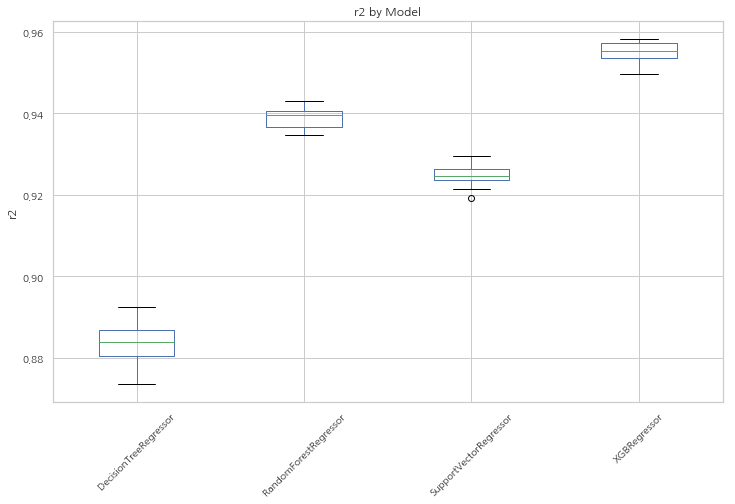

In [19]:
## boxplot
plt.figure(figsize=(12, 7))
r2_score.boxplot(column= ['DecisionTreeRegressor', 'RandomForestRegressor', 'SupportVectorRegressor', 'XGBRegressor']) 
plt.xticks(size = 10, rotation=45)
plt.yticks(size = 10)
plt.title('r2 by Model')
plt.ylabel("r2")
plt.show()